In [2]:
import os
from datetime import datetime
import json
import pandas as pd

In [3]:
prompt_templates = {}
prompt_templates['p1']={'role': None,
    'example':"The following snippet is a confirmed vulnerable code with a severity score of {}:  {}",
          'question':"What is the vulnerability severity score for the following snippet?   {}"}
          
prompt_templates['p2']={'role':'You are a software code vulnerability inspector, CVSS score is a number between 0.0 and 10.0',
        'example':"The following snippet is a vulnerable code with a CVSS score of {}:  {}",
        'question':"What is the CVSS score for the following snippet?  {}"}
        
prompt_templates['p3']={'role':'You are a software code vulnerability inspector and you should to provide a CVSS score depending on the severity. a CVSS score is a number between 0.0 and 10.0',
        'example':"The following vulnerability description has a escore of {}:  {}",
        'question':"What is the CVSS score from the following description?  {}"}

  

In [4]:
N_EXAMPLES= 3

In [5]:
MIN_LEN = 100

In [31]:
MAX_LEN = 300

In [32]:
val_data = pd.read_csv("../../data/big-vul/train.csv")

In [33]:
filtered_val = val_data[val_data['func_before'].str.len().between(MIN_LEN,MAX_LEN)]
filtered_val = filtered_val[filtered_val['Score'].notna()]
filtered_val.shape

(53010, 39)

In [34]:
test_data = pd.read_csv("../../data/big-vul/test.csv")

In [35]:
filtered_test = test_data[test_data['func_before'].str.len().between(MIN_LEN,MAX_LEN)]
filtered_test = filtered_test[filtered_test['Score'].notna()]
filtered_test.shape

(6720, 39)

In [13]:
def build_messages(data_example,data_query, prompt_template):
    messages = []
    indexes = []
    gt = None
    if (role_template := prompt_template['role']) :
        messages.append(role_template)
    p1_template = prompt_template['example']
    p2_template = prompt_template['question']
    for i in range(N_EXAMPLES):
        random_row = data_example.sample(n=1)
        text = random_row['func_before'].values[0]
        score = random_row['Score'].values[0]
        message = p1_template.format(score, text)
        indexes.append(int(random_row['index'].values[0]))
        messages.append(message)
    random_row = data_query.sample(n=1)
    text = random_row['func_before'].values[0]
    gt = random_row['Score'].values[0]
    message = p2_template.format(text)
    indexes.append(int(random_row['index'].values[0]))
    messages.append(message)
    return messages, indexes, gt

In [14]:
messages, indexes, gt_score = build_messages(filtered_val, filtered_test, prompt_templates['p2'])

In [15]:
messages

['You are a software code vulnerability inspector, CVSS score is a number between 0.0 and 10.0',
 'The following snippet is a vulnerable code with a CVSS score of 5.0:  static void fix_all_wrapped_labels(GtkWidget *widget)\n{\n    wrap_fixer(widget, NULL);\n}\n',
 'The following snippet is a vulnerable code with a CVSS score of 6.8:  base::Time DownloadItemImpl::GetEndTime() const {\n  return destination_info_.end_time;\n}\n',
 'The following snippet is a vulnerable code with a CVSS score of 4.3:      void advanceClock(double seconds)\n    {\n        m_proxyPlatform.advanceClock(seconds);\n    }\n',
 'What is the CVSS score for the following snippet?  FrameView* Document::view() const\n{\n    return m_frame ? m_frame->view() : 0;\n}\n']

## Population Size 

In [36]:
filtered_test_size=filtered_test.shape[0]

In [37]:
filtered_test_size

6720

In [38]:
TRIALS=385//(1+(384/filtered_test_size))

In [39]:
residual = TRIALS % 100
TRIALS = TRIALS + (100 -residual) 

In [40]:
TRIALS

400.0

In [29]:
for i in range(int(TRIALS)):
    messages, indexes, gt_score = build_messages(filtered_val, filtered_test, prompt_templates['p2'])

In [30]:
messages

['You are a software code vulnerability inspector, CVSS score is a number between 0.0 and 10.0',
 'The following snippet is a vulnerable code with a CVSS score of 7.5:    tt_driver_done( FT_Module  ttdriver )     /* TT_Driver */\n  {\n    FT_UNUSED( ttdriver );\n  }\n',
 'The following snippet is a vulnerable code with a CVSS score of 6.8:  void ConnectionInfoPopupAndroid::Destroy(JNIEnv* env, jobject obj) {\n  delete this;\n}\n',
 'The following snippet is a vulnerable code with a CVSS score of 7.5:  EventTargetData* RTCPeerConnection::eventTargetData()\n{\n    return &m_eventTargetData;\n}\n',
 'What is the CVSS score for the following snippet?    static void  Ins_SCVTCI( INS_ARG )\n  {\n    CUR.GS.control_value_cutin = (TT_F26Dot6)args[0];\n  }\n']

In [41]:
filtered_val.head()

,index,Access Gained,Attack Origin,Authentication Required,Availability,CVE ID,CVE Page,CWE ID,Complexity,Confidentiality,...,parentID,patch,project,project_after,project_before,target,vul_func_with_fix,processed_func,flaw_line,flaw_line_index
1,24444,NaN,Local,Not required,NaN,CVE-2011-4080,https://www.cvedetails.com/cve/CVE-2011-4080/,CWE-264,High,Complete,...,NaN,"@@ -170,6 +170,11 @@ static int proc_taint(str...",linux,bfdc0b497faa82a0ba2f9dddcf109231dd519fcc,cb16e95fa2996743a6e80a665ed2ed0590bd38cf,0,void register_sysctl_root(struct ctl_table_roo...,void register_sysctl_root(struct ctl_table_roo...,NaN,NaN
3,1314,NaN,Remote,Not required,Complete,CVE-2009-3604,https://www.cvedetails.com/cve/CVE-2009-3604/,CWE-399,Medium,Complete,...,75c3466ba2e4980802e80b939495981240261cd5,"@@ -216,6 +216,28 @@ void *gmallocn_checkoverf...",poppler,https://cgit.freedesktop.org/poppler/poppler/t...,https://cgit.freedesktop.org/poppler/poppler/t...,0,"char *gstrndup(const char *s, size_t n) {\n c...","char *gstrndup(const char *s, size_t n) {\n c...",NaN,NaN
12,164710,NaN,Remote,Not required,Partial,CVE-2019-5809,https://www.cvedetails.com/cve/CVE-2019-5809/,CWE-416,Medium,Partial,...,NaN,"@@ -33,6 +33,7 @@\n #include ""content/public/b...",Chrome,4a3482693491ac6bb3dd27d591efa3de1d1f1fcf,db485cc29436d0547a6f5f86ef4534fb50865a12,0,explicit SecurityExploitTestInterstitialPag...,explicit SecurityExploitTestInterstitialPag...,NaN,NaN
14,80620,NaN,Remote,Not required,Partial,CVE-2018-13006,https://www.cvedetails.com/cve/CVE-2018-13006/,CWE-125,Low,Partial,...,NaN,"@@ -632,7 +632,7 @@ GF_Err urn_Read(GF_Box *s,...",gpac,bceb03fd2be95097a7b409ea59914f332fb6bc86,2ce4dcf583601a23ce328dfa44f9c57fe8ea6156,0,"GF_Err tsro_Read(GF_Box *s, GF_BitStream *bs)\...","GF_Err tsro_Read(GF_Box *s, GF_BitStream *bs)\...",NaN,NaN
15,154535,NaN,Remote,Not required,Partial,CVE-2016-5219,https://www.cvedetails.com/cve/CVE-2016-5219/,CWE-416,Medium,Partial,...,NaN,"@@ -2056,16 +2056,26 @@ bool GLES2DecoderPasst...",Chrome,a4150b688a754d3d10d2ca385155b1c95d77d6ae,afa5506de063d1d6fd1a854c825b568337c29bc7,0,void GLES2DecoderPassthroughImpl::UpdateTextur...,void GLES2DecoderPassthroughImpl::UpdateTextur...,NaN,NaN


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
desc_stats = filtered_val.describe(include='all')


In [48]:
# 2. Correlation Matrix (only include numeric columns)
numeric_df = filtered_val.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

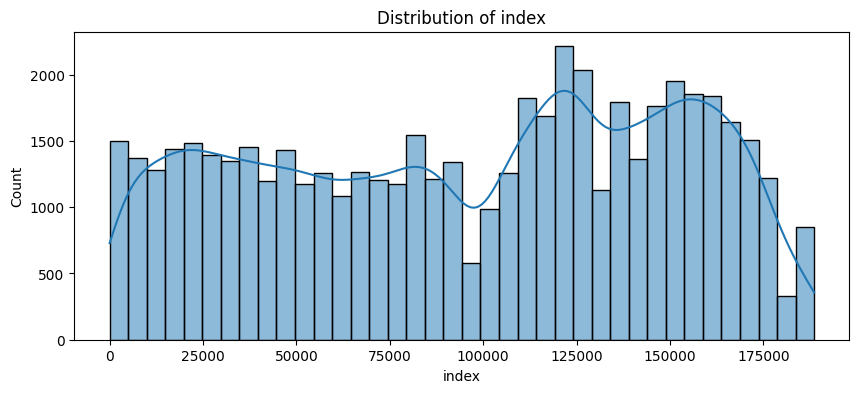

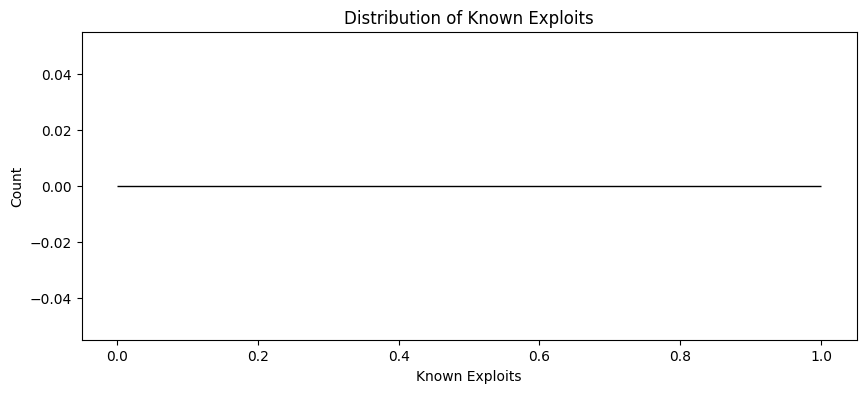

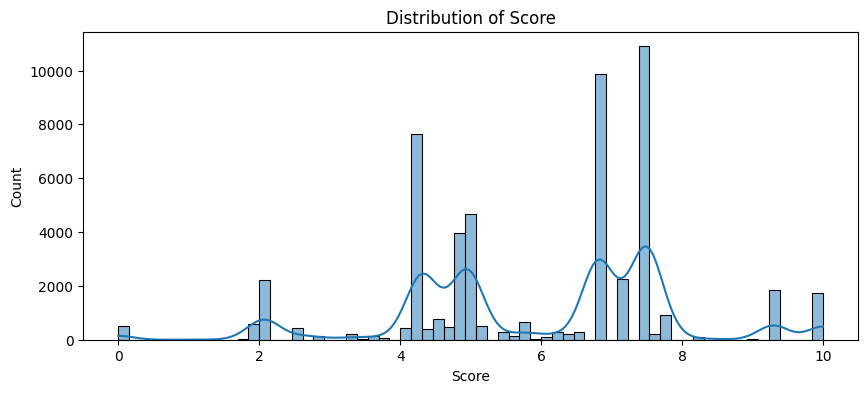

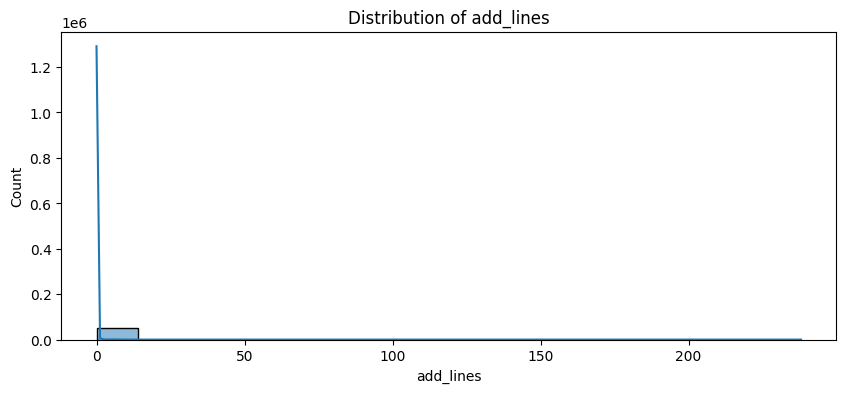

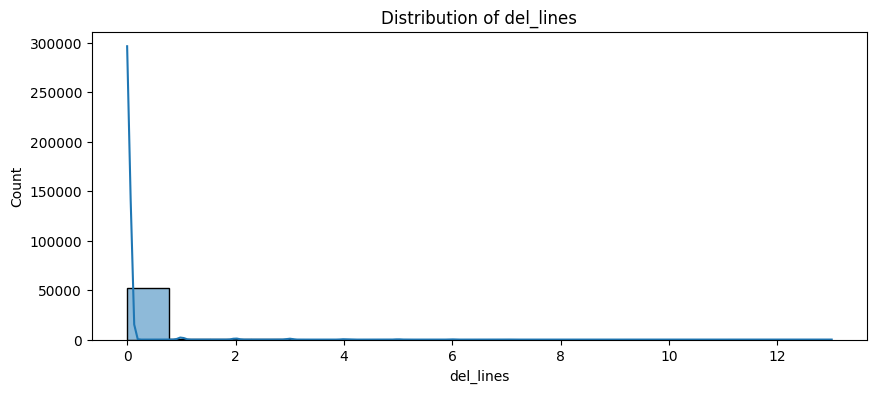

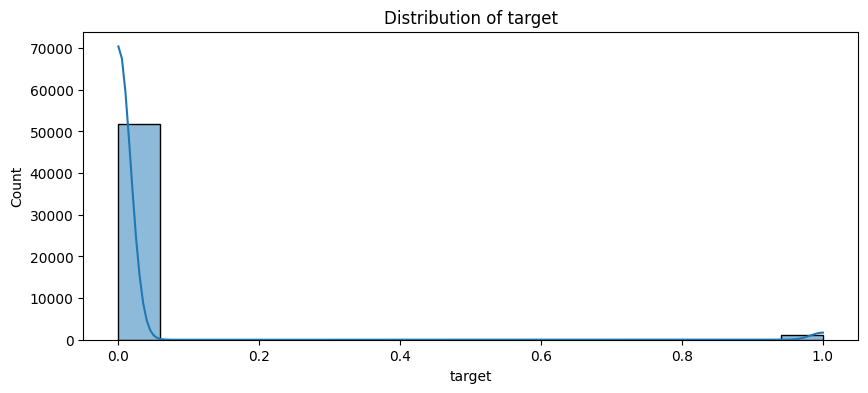

In [47]:
for column in filtered_val.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(filtered_val[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

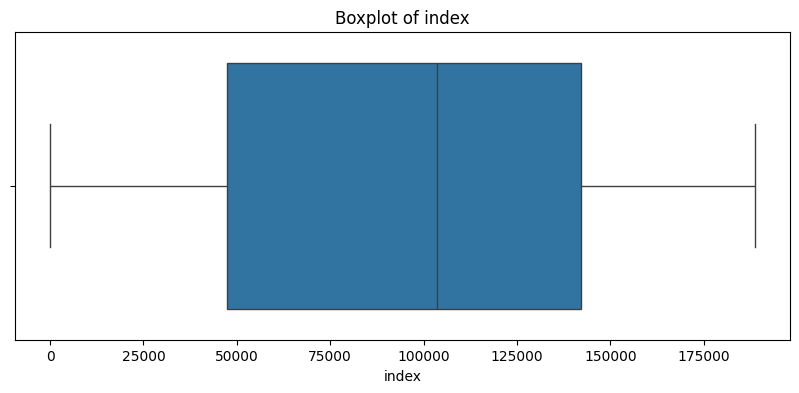

ValueError: List of boxplot statistics and `positions` values must have same the length

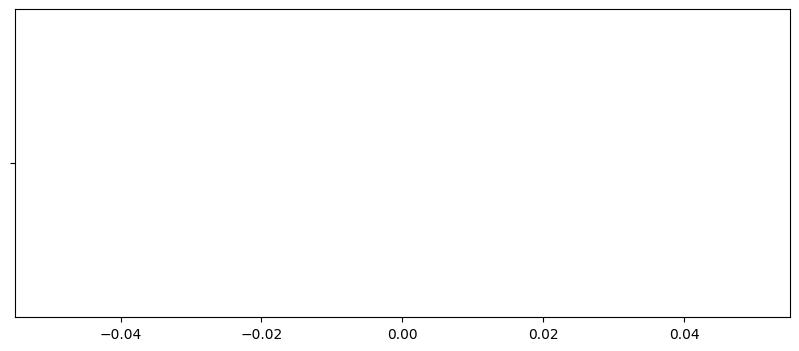

In [49]:
# 4. Outliers Detection
for column in numeric_df.columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=numeric_df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()


In [56]:
column_name = 'Score'

# Ensure the column is numeric
if pd.api.types.is_numeric_dtype(filtered_test[column_name]):
    # Get descriptive statistics
    stats = filtered_test[column_name].describe()
    
    # Create a summary table with mean, count, and quartiles
    summary_table = pd.DataFrame({
        'Count': [stats['count']],
        'Mean': [stats['mean']],
        'Min': [stats['min']],
        'Max': [stats['max']],
        'Std': [stats['std']],
        '25% (Q1)': [stats['25%']],
        '50% (Median)': [stats['50%']],
        '75% (Q3)': [stats['75%']]
    })
    
    print(summary_table)
else:
    print(f"The column '{column_name}' is not numeric.")

    Count      Mean  Min   Max       Std  25% (Q1)  50% (Median)  75% (Q3)
0  6720.0  6.056131  0.0  10.0  1.909476       4.7           6.8       7.5


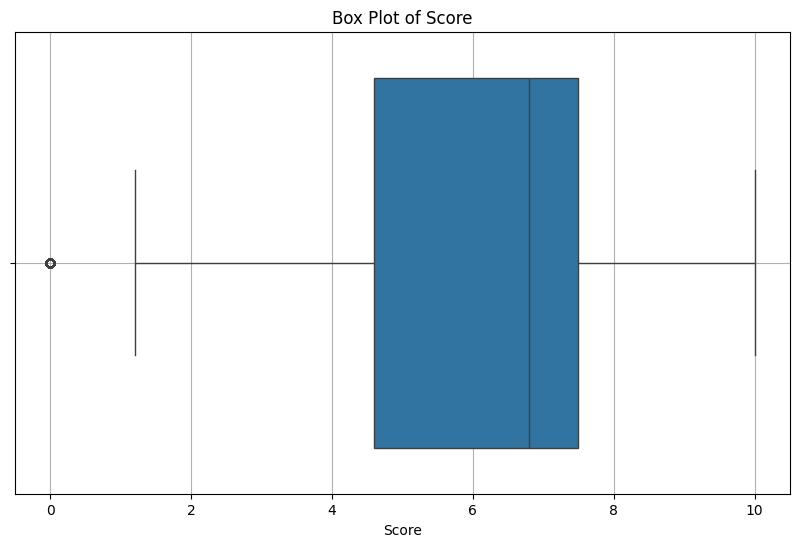

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_val[column_name])
plt.title(f'Box Plot of {column_name}')
plt.xlabel(column_name)
plt.grid(True)
plt.show()

/tmp/ipykernel_2880964/3081425018.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


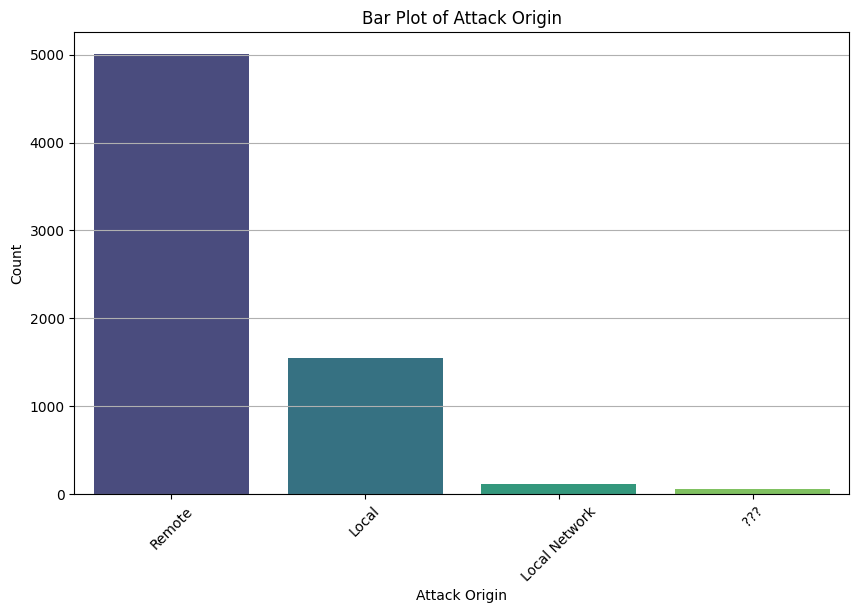

In [62]:
# Specify the categorical column you are interested in
column_name = 'Attack Origin'

# Ensure the column is categorical
if filtered_test[column_name].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column_name]):
    # Get the value counts
    value_counts = filtered_test[column_name].value_counts()
    
    # Plot the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")
    plt.title(f'Bar Plot of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()